In [1]:
%matplotlib inline
import warnings

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf

from poisson_solve import solve_2D_poisson_fd

In [13]:
def stfunc_to_vorticity(psi, dx, dy):
    """
    stfunc = stream function
    
    Parameter:
    ---------
    psi: 2d-array, shape=(ny, nx)
        Stream Function.
    dx, dy: int or float
        The horizontal resolution.
    
    Return:
    ------
    Vorticity field.
    """
    ny, nx = psi.shape
    vorticity = np.zeros((ny, nx))
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            vorticity[j,i] = ( (psi[j,i+1] - 2*psi[j,i] + psi[j,i-1]) / dx**2   
                               + (psi[j+1,i] - 2*psi[j,i] + psi[j-1,i]) / dy**2 )
    vorticity[0,:] = vorticity[1,:]
    vorticity[-1,:] = vorticity[-2,:]
    vorticity[:,0] = vorticity[:,1]
    vorticity[:,-1] = vorticity[:,-2]
    return vorticity

In [45]:
def laplace_relaxation(Z_init, Y, dx, dy, alpha=0.5, epsilon=0.02, max_iter=500):
    """
    Given Y, solve Z which satisfy Laplacian(Z)=Y.
    The boundary of Z would be set to 0.
    """
    Z = Z_init
    ny, nx = Z.shape
    residual = np.zeros((ny, nx))
    
    n_iter = 0
    while True:
        for j in range(1, ny-1):
            for i in range(1, nx-1):
                residual[j,i] = ( (Z[j,i+1] - 2*Z[j,i] + Z[j,i-1]) / dx**2
                                  + (Z[j+1,i] - 2*Z[j,i] + Z[j-1,i]) / dy**2 
                                  - Y[j,i] )
        dZ = (1+alpha) * residual / (2 * (1/dx**2 + 1/dy**2))
        Z += dZ
        n_iter += 1
        
        if np.all(np.abs(dZ) < epsilon):
            break
        elif n_iter >= max_iter:
            warnings.warn('The iteration has not converage.')
            break
            
    return Z

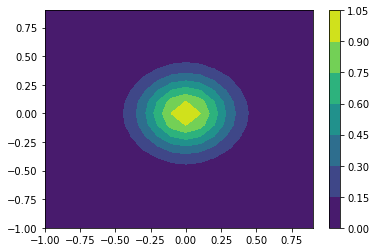

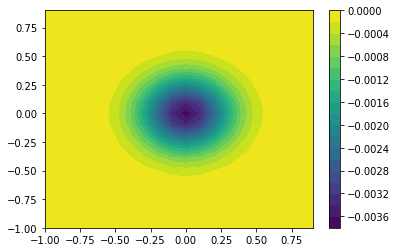

In [46]:
#http://ammar-hakim.org/sj/je/je1/je1-periodic-poisson.html
X, Y = np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1))
s = np.exp(-10 * X**2 - 10 *Y**2)
plt.contourf(X, Y, s)
plt.colorbar()

plt.figure()
Z_init = np.zeros_like(X)
res = laplace_relaxation(Z_init, s, 0.1, 0.1)
plt.contourf(X, Y, res, levels=20)
plt.colorbar()

In [3]:
import wrf

f = netcdf.netcdf_file('../../MY_WRF_test/wrfout_d01_2017-08-21_00_00_00')
lat = f.variables['XLAT'].data
lon = f.variables['XLONG'].data
p = f.variables['P'].data + f.variables['PB'].data
p *= 0.01  # Pa to hPa

print(wrf.getvar(f, 'avo').units)
avo = wrf.getvar(f, 'avo', wrf.ALL_TIMES).values * 10**-5
avo.shape   # time, z, y, x

10-5 s-1


(17, 29, 66, 81)

In [4]:
fc = f.variables['F'][:]
fc.shape   # time, y, x

(17, 66, 81)

In [5]:
rvo = avo - fc[:,np.newaxis,:,:]  # relative vorticity
rvo.shape

(17, 29, 66, 81)

In [6]:
# interp rvo to 500hPa
rvo500 = wrf.interpz3d(rvo, p, np.array([500]), missing=np.nan)
rvo500 = np.squeeze(rvo500.values)
rvo500.shape

(17, 66, 81)

In [7]:
# get stream function from solve: laplacian(psi) = rvo
ini_rvo500 = rvo500[0,1:-1,1:-1]
psi = solve_2D_poisson_fd(81, 66, 45000, 45000, ini_rvo500.reshape((-1, 1)))

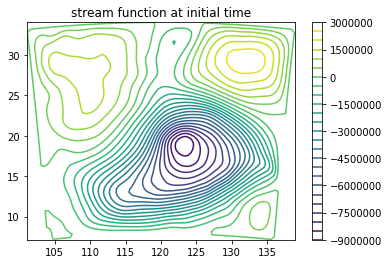

In [29]:
plt.contour(lon[0,:,:], lat[0,:,:], psi, 25)
plt.colorbar()
plt.title('stream function at initial time');

In [27]:
def d_dx(var, dx):
    dvar_dx = np.zeros(var.shape)
    
    dvar_dx[:, 0] = (var[:, 1] - var[:, 0]) / dx     # FDM
    dvar_dx[:, -1] = (var[:, -1] - var[:, -2]) / dx  # BDM
    for i in range(1, var.shape[1]-1):
        dvar_dx[:,i] = (var[:,i+1] - var[:,i-1]) / (2 * dx)   # CDM
        
    return dvar_dx


def d_dy(var, dy):
    dvar_dy = np.zeros(var.shape)
    
    dvar_dy[0,:] = (var[1,:] - var[0,:]) / dy      # FDM
    dvar_dy[-1,:] = (var[-1,:] - var[-2,:]) / dy   # BDM
    for j in range(1, var.shape[0]-1):
        dvar_dy[j,:] = (var[j+1,:] - var[j-1,:]) / (2 * dy)   # CDM
    
    return dvar_dy

In [46]:
beta = d_dy(fc[0,:,:], 45000)
beta.shape

(66, 81)

In [50]:
v = d_dx(psi, 45000)
u = -d_dy(psi, 45000)
vorticity = stfunc_to_vorticity(psi, 45000, 45000)

F = -d_dx(u*vorticity, 45000) - d_dy(v*vorticity, 45000) - beta * v

Please wait for a moment
Iteration finished


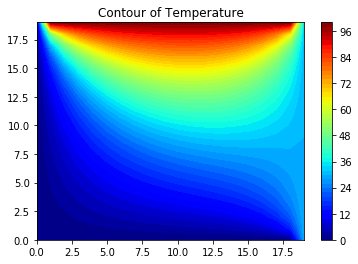

In [26]:
# Set maximum iteration
maxIter = 500

# Set Dimension and delta
lenX = lenY = 20 #we set it rectangular
delta = 1

# Boundary condition
Ttop = 100
Tbottom = 0
Tleft = 0
Tright = 30

# Initial guess of interior grid
Tguess = 30

# Set colour interpolation and colour map
colorinterpolation = 50
colourMap = plt.cm.jet #you can try: colourMap = plt.cm.coolwarm

# Set meshgrid
X, Y = np.meshgrid(np.arange(0, lenX), np.arange(0, lenY))

# Set array size and set the interior value with Tguess
T = np.empty((lenX, lenY))
T.fill(Tguess)

# Set Boundary condition
T[(lenY-1):, :] = Ttop
T[:1, :] = Tbottom
T[:, (lenX-1):] = Tright
T[:, :1] = Tleft

# Iteration (We assume that the iteration is convergence in maxIter = 500)
print("Please wait for a moment")
for iteration in range(0, maxIter):
    for i in range(1, lenX-1, delta):
        for j in range(1, lenY-1, delta):
            T[i, j] = 0.25 * (T[i+1][j] + T[i-1][j] + T[i][j+1] + T[i][j-1])

print("Iteration finished")

# Configure the contour
plt.title("Contour of Temperature")
plt.contourf(X, Y, T, colorinterpolation, cmap=colourMap)

# Set Colorbar
plt.colorbar()